In [5]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime
import os
import sys
sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from IPython.display import Image
from OP_functions import *
rc('animation', html='html5')

In [7]:
def make_prefix(date, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """
    path = '/results2/SalishSea/nowcast-green.202111/'
    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

In [36]:
#Pick hour,day and location.
hour = 0
path_NEMO = make_prefix(datetime(2018, 8, 1))
lati = 48.240856318030914
loni = -123.44358372742191
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]

#Specify some simulation parameters
T = 5e3 #s (run time)
dt = 5 #s (timestep)
N = 10e3 #number of particles
outputdt = 500 #s (how often do you want output?)
outputpath = '/home/jvalenti/MOAD/results/Outputmix.zarr'

In [45]:
#Load data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False)
mbathy = xr.open_dataset('/ocean/jvalenti/MOAD/grid/mesh_mask202108.nc').mbathy[0,j,i].item()
depth = np.array(Wdat.depthw[:mbathy]).astype('float32')
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy,j,i]).astype('float32')
#Kz_col[0]=Kz_col[1]

In [46]:
xr.open_dataset('/ocean/jvalenti/MOAD/grid/mesh_mask202108.nc').mbathy[0,j,i].item()

29

/tmp/ipykernel_1530610/3686291716.py:6: RuntimeWarning: divide by zero encountered in divide
  dtmax = np.min(1/abs(Kzp2))


Dt should be << 112.42830918585231


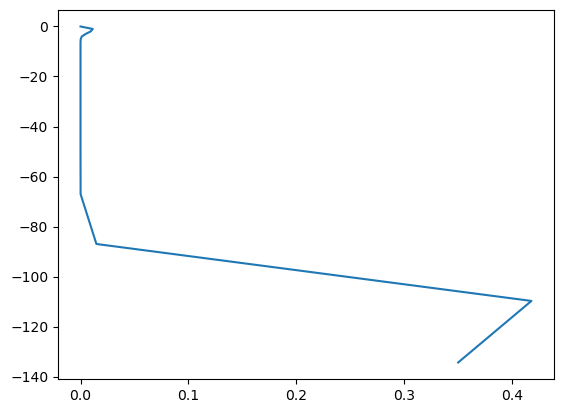

In [47]:
depth2 = np.arange(depth[0],depth[-1],1)
Kz2 = np.interp(depth2, depth, Kz_col)
plt.plot(Kz_col,-depth)
Kzp = np.gradient(Kz2, depth2[1]-depth2[0])
Kzp2 = np.gradient(Kzp, depth2[1]-depth2[0])
dtmax = np.min(1/abs(Kzp2))
print(f'Dt should be << {dtmax}')

In [116]:
#Here you can define as many particle variables as you want specifying the initial values. In this case, I use the variable to set a constant.
class MPParticle(JITParticle):
    Kh = Variable('Kh', initial =  0.0) #If you want horizontal mixing activated change value here
    bath = Variable('bath', initial= depth[-1])

In [117]:
#Mixing Kernel
def tu_mix(particle,fieldset,time):
    bath= particle.bath #109.73707
    if particle.depth+1 > bath: #Forward euler
        Kzdz = (fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-1,particle.lat, particle.lon]) #forward difference 
    else:
        Kzdz = (fieldset.Kz[time,particle.depth+1,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, bath,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Kx = particle.Kh
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [118]:
#Define domain, velocity fields and Kz 
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)

#Build fieldsets for OP
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col   
Kz = Field('Kz', Kz_data, grid=U.grid)
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [119]:
#Start with random distribution
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(int(N),))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(int(N),))
lat_g = np.zeros(int(N),)

In [120]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
    output_file = pset.ParticleFile(name=outputpath, outputdt=outputdt)
    KE=tu_mix #if you want to add more kernels use:  KE = tu_mix + NAME_KERNEL1 + ...
    pset.execute(KE , runtime=T, dt=dt, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

In [121]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2894/lib366c5b8075e7b5a447a04d7978fcae20_0.so


In [122]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/Outputmix.zarr')

/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [123]:
def anim2(file1,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,3,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
    axs[2].plot(Kz_col,depth,c='r')
    axs[2].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[2].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title(f"With $K_z$' correction (t: {T:.2e}s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))         
        print(f'{100*frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1),fps))

In [124]:
# ss =[]
# ani = anim2(dat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/mix.gif" 
# FFwriter = animation.FFMpegWriter()
# a = ani.save(f, writer = FFwriter)

In [125]:
# with open(f,'rb') as anim:
#      display(Image(anim.read()))

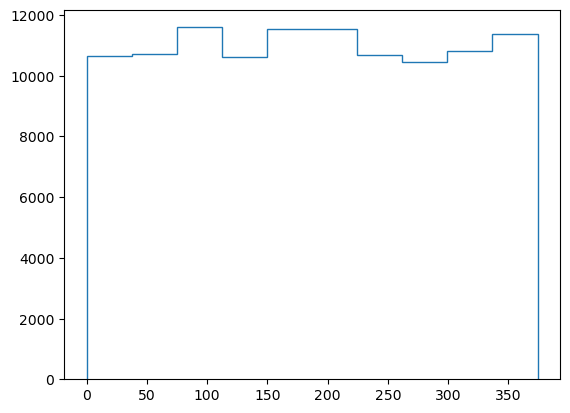

In [134]:
counts, bins = np.histogram(dat.z, bins = 10)
plt.stairs(counts, bins)